In [13]:
!pip install cvxpy

     ---------------------------------------- 1.1/1.1 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 293.1/293.1 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 72.0/72.0 kB 1.9 MB/s eta 0:00:00
     -------------------------------------- 321.5/321.5 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 8.4/8.4 MB 7.9 MB/s eta 0:00:00
     ---------------------------------------- 87.4/87.4 kB 5.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [5]:
df = pd.read_excel("teste_controle_sintetico.xlsx")

In [6]:
df.head()

,ANOMES,ID,T,TD,Y,X
0,2023-01-01,1,1,0,121,140
1,2023-02-01,1,1,0,16,17
2,2023-03-01,1,1,0,48,64
3,2023-04-01,1,1,0,32,37
4,2023-05-01,1,1,0,132,133


In [7]:
treated = list(df.query("T==1")["ID"].unique())
treated

[1, 2, 3]

In [8]:
tr_period = df.query("TD==1")["ANOMES"].min()
tr_period

Timestamp('2024-05-01 00:00:00')

In [9]:
def reshape_sc_data(df: pd.DataFrame, geo_col: str,  time_col: str, y_col: str, tr_geos: str, tr_start: str):
    df_pivot = df.pivot(time_col, geo_col, y_col)
    y_co = df_pivot.drop(columns=tr_geos)
    y_tr = df_pivot[tr_geos]
    y_pre_co = y_co[df_pivot.index < tr_start]
    y_pre_tr = y_tr[df_pivot.index < tr_start]
    y_post_co = y_co[df_pivot.index >= tr_start]
    y_post_tr = y_tr[df_pivot.index >= tr_start]
    return y_pre_co, y_pre_tr, y_post_co, y_post_tr

In [10]:
y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshape_sc_data(df, 
                                                            geo_col="ID", 
                                                            time_col="ANOMES", 
                                                            y_col="Y", 
                                                            tr_geos=treated, 
                                                            tr_start=str(tr_period))
y_pre_tr.head()

C:\Users\gcabr\AppData\Local\Temp\ipykernel_8048\705883185.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot(time_col, geo_col, y_col)


ID,1,2,3
ANOMES,,,
2023-01-01,121,130,146
2023-02-01,16,65,128
2023-03-01,48,62,112
2023-04-01,32,129,130
2023-05-01,132,143,140


In [16]:
y_pre_co.head()

ID,4,5,6,7,8,9,10
ANOMES,,,,,,,
2023-01-01,78,130,26,81,73,114,33
2023-02-01,128,46,139,123,22,81,80
2023-03-01,137,60,134,65,105,47,106
2023-04-01,111,64,44,58,14,123,79
2023-05-01,104,87,31,39,144,129,88


# Primeira Versao

In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):
    def __init__(self,):
        pass

    def fit(self, y_pre_co, y_pre_tr):
        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)
            
        w = cp.Variable(y_pre_co.shape[1])
        
        objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr))
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        self.loss_ = problem.solve(verbose=False)
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
    
    def predict(self, y_co):
        check_is_fitted(self)
        y_co = check_array(y_co)
        
        return y_co @ self.w_

In [15]:
model = SyntheticControl()
model.fit(y_pre_co, y_pre_tr.mean(axis=1))
# extrac the weights
model.w_.round(3)

array([-0.   ,  0.498, -0.   , -0.   ,  0.077,  0.425, -0.   ])

In [18]:
y0_tr_hat = y_post_co.dot(model.w_)

In [19]:
y0_tr_hat.head()

ANOMES
2024-05-01     69.484905
2024-06-01     73.497012
2024-07-01     17.368147
2024-08-01    139.665321
2024-09-01     58.206204
dtype: float64

<AxesSubplot: xlabel='ANOMES'>

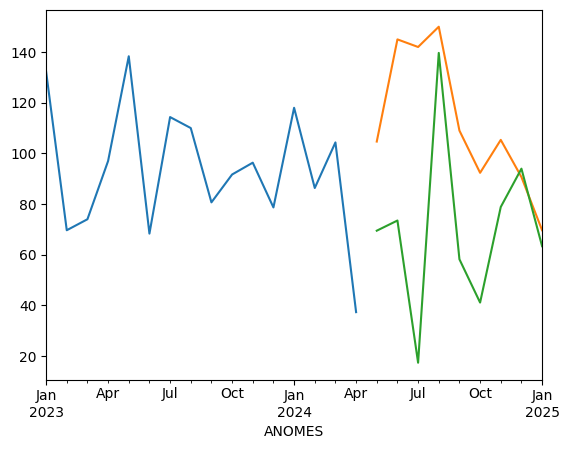

In [65]:
y_pre_tr.mean(axis=1).plot()
y_post_tr.mean(axis=1).plot()
y0_tr_hat.plot()

In [21]:
att = y_post_tr.mean(axis=1) - y0_tr_hat

# Com covariavel

In [33]:
from toolz import partial

In [36]:
reshaper = partial(reshape_sc_data,
                            df=df,
                            geo_col="ID",
                            time_col="ANOMES",
                            tr_geos=treated,
                            tr_start=str(tr_period))
y_pre_co, y_pre_tr, y_post_co, y_post_tr = reshaper(y_col="Y")
x_pre_co, _, x_post_co, _ = reshaper(y_col="Y")

C:\Users\gcabr\AppData\Local\Temp\ipykernel_8048\705883185.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot(time_col, geo_col, y_col)
C:\Users\gcabr\AppData\Local\Temp\ipykernel_8048\705883185.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = df.pivot(time_col, geo_col, y_col)


In [48]:
def find_w_given_vs(vs, x_co_list, y_tr_pre):
    X_times_v = sum([x*v for x, v in zip(x_co_list, vs)])
    
    model = SyntheticControl()
    model.fit(X_times_v, y_tr_pre)
    
    return {"loss": model.loss_, "w": model.w_}

In [133]:
from scipy.optimize import minimize

def v_loss(vs):
    return find_w_given_vs(vs,[y_pre_co, x_pre_co],
    y_pre_tr.mean(axis=1)).get("loss")

v_solution = minimize(v_loss, [0, 0], method='L-BFGS-B')
v_solution.x

array([0.54774658, 0.54774658])

In [51]:
w_cov = find_w_given_vs(v_solution.x,[y_pre_co, x_pre_co],
         y_pre_tr.mean(axis=1)).get("w").round(3)

In [52]:
w_cov

array([-0.   ,  0.508, -0.   , -0.   ,  0.105,  0.366,  0.022])

In [54]:
y0_hat = sum([x*v for x, v in zip([y_post_co, x_post_co], v_solution.x)]).dot(w_cov)

In [55]:
y0_hat

ANOMES
2024-05-01     79.633589
2024-06-01     84.808698
2024-07-01     20.035474
2024-08-01    149.757201
2024-09-01     63.733601
2024-10-01     45.278923
2024-11-01     89.646396
2024-12-01    101.176461
2025-01-01     68.068467
dtype: float64

<AxesSubplot: xlabel='ANOMES'>

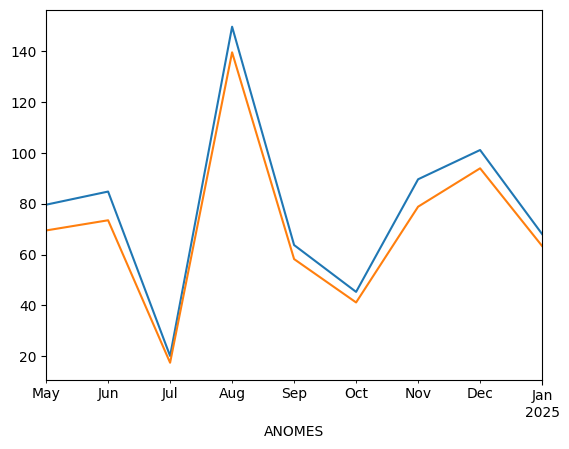

In [68]:
y0_hat.plot()
y0_tr_hat.plot()

In [69]:
att_new = y_post_tr.mean(axis=1) - y0_hat

<AxesSubplot: xlabel='ANOMES'>

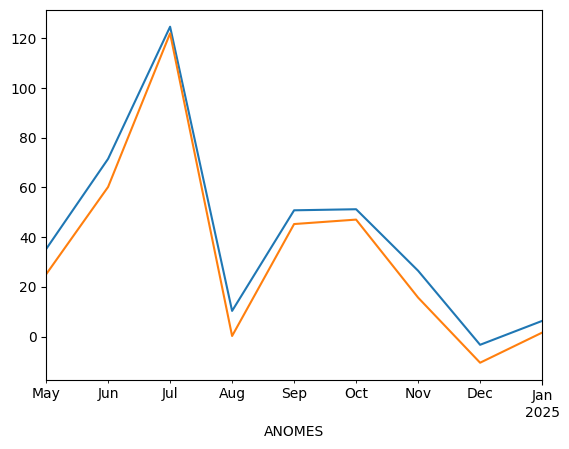

In [77]:
att.plot()
att_new.plot()

# Debising

In [105]:
def debiased_sc_atts(y_pre_co, y_pre_tr, y_post_co, y_post_tr, K=2):
    block_size = int(min(np.floor(len(y_pre_tr)/K), len(y_post_tr)))
    blocks = np.split(y_pre_tr.index[-K*block_size:], K)
    
    def fold_effect(hold_out):
        model = SyntheticControl()
        model.fit(
        y_pre_co.drop(hold_out),
        y_pre_tr.drop(hold_out)
        )
        
        bias_hat = np.mean(y_pre_tr.loc[hold_out]- model.predict(y_pre_co.loc[hold_out]))
        y0_hat = model.predict(y_post_co)
    
        return (y_post_tr - y0_hat) - bias_hat

    return pd.DataFrame([fold_effect(block) for block in blocks]).T

In [110]:
deb_atts = debiased_sc_atts(y_pre_co, y_pre_tr.mean(axis=1), y_post_co, y_post_tr.mean(axis=1), K=2)

In [126]:
deb_atts.head(15)

,0,1
ANOMES,,
2024-05-01,-5.097380,31.839369
2024-06-01,19.937761,71.019446
2024-07-01,94.951131,122.076548
2024-08-01,-6.088374,3.844068
2024-09-01,36.292458,45.207508
2024-10-01,29.049058,46.037597
2024-11-01,-7.721323,23.492750
2024-12-01,-20.016959,-8.594753
2025-01-01,1.478320,-4.265787


In [112]:
deb_atts.mean(axis=1)

ANOMES
2024-05-01     13.370995
2024-06-01     45.478604
2024-07-01    108.513840
2024-08-01     -1.122153
2024-09-01     40.749983
2024-10-01     37.543327
2024-11-01      7.885713
2024-12-01    -14.305856
2025-01-01     -1.393733
dtype: float64

In [120]:
atts_k = deb_atts.mean(axis=0).values
att = np.mean(atts_k)

In [122]:
atts_k

array([15.86496582, 36.73963859])

In [123]:
att

26.302302200550038

# Inferencia

In [125]:
K = len(atts_k)
T0 = len(y_pre_co)
T1 = len(y_post_co)
block_size = min(np.floor(T0/K), T1)
se_hat=np.sqrt(1+((K*block_size)/T1))*np.std(atts_k, ddof=1)/np.sqrt(K)

from scipy.stats import t
alpha = 0.05
[att - t.ppf(1-alpha/2, K-1)*se_hat,
att + t.ppf(1-alpha/2, K-1)*se_hat]

[-194.72925282172602, 247.33385722282608]